<a href="https://colab.research.google.com/github/PradyumnaGupta/pcb_defect_analysis/blob/master/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data

In [ ]:
!git clone https://github.com/tangsanli5201/DeepPCB.git

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 26.28 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Checking out files: 100% (4548/4548), done.


In [ ]:
!mkdir train_images
!mkdir val_images

In [ ]:
import cv2

def subtract_image(image_path_1,image_path_2):
    image1 = cv2.imread(image_path_1)
    image2 = cv2.imread(image_path_2)
    difference = cv2.subtract(image1, image2)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    image1[mask != 255] = [0, 0, 255]
    image2[mask != 255] = [0, 0, 255]
    return image2

# import cv2

# def subtract_image(image_path_1,image_path_2):
#     image1 = cv2.imread(image_path_1)
#     image2 = cv2.imread(image_path_2)
#     difference = cv2.subtract(image1, image2)
#     Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
#     ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
#     difference[mask != 255] = [0, 0, 255]

#     difference = cv2.subtract(image2, image1)
#     Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
#     ret, mask1 = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
#     difference[mask1 != 255] = [0, 0, 255]

#     image1[mask != 255] = [0, 0, 255]
#     image2[mask != 255] = [0, 0, 255]
#     image2[mask1 != 255] = [0, 255, 0]


#     return image2    

In [ ]:
import os,glob
from tqdm import tqdm

groups = glob.glob("/content/DeepPCB/PCBData/*")

train_data = []
val_data = []

count = 0

for group in groups:
  try :
    images_folder,txts_folder = sorted(os.listdir(group))
  except:
    continue
  group+="/"
  template_images = sorted(glob.glob(group + images_folder + "/*_temp.jpg"))
  test_images = sorted(glob.glob(group + images_folder + "/*_test.jpg"))
  txts = sorted(glob.glob(group + txts_folder))

  for i,(img1,img2) in tqdm(enumerate(zip(template_images,test_images))):
    image = subtract_image(img1,img2)
    index = img1.split("/")[-1].split("_")[0]
    try:
      with open(group+txts_folder+"/"+index+".txt") as f:
        for line in f:
          line = list(map(int,line.split("\n")[0].split(" ")))
          if i>0.9*len(test_images):
            cv2.imwrite("val_images/extract_{}.jpg".format(count),image[line[1]:line[3],line[0]:line[2]])
            val_data.append(["extract_{}.jpg".format(count),line[4]])
          else :  
            cv2.imwrite("train_images/extract_{}.jpg".format(count),image[line[1]:line[3],line[0]:line[2]])
            train_data.append(["extract_{}.jpg".format(count),line[4]])
          count+=1
    except:
       continue     

14it [00:00, 77.77it/s]
325it [00:03, 88.30it/s]
146it [00:01, 88.11it/s]
100it [00:01, 91.18it/s]
74it [00:01, 70.43it/s]
120it [00:01, 93.67it/s]
79it [00:00, 89.60it/s]
216it [00:02, 90.65it/s] 
221it [00:02, 88.94it/s]
98it [00:01, 80.32it/s]
107it [00:01, 99.27it/s]


In [ ]:
import pandas as pd

train = pd.DataFrame(train_data)
train.columns = ["name","label"]
val = pd.DataFrame(val_data)
val.columns = ["name","label"]

In [ ]:
train.to_csv("pcb_train.csv",index=False)
val.to_csv("pcb_val.csv",index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv train_images drive/MyDrive/pcb_train_images
!mv val_images drive/MyDrive/pcb_val_images

!mv pcb_train.csv drive/MyDrive/
!mv pcb_val.csv drive/MyDrive/

In [ ]:
import cv2,glob

imgs = glob.glob("drive/MyDrive/pcb_train_images/*")

max_l = 0
max_h = 0 

for img in imgs:
  s = cv2.imread(img).shape
  max_l = max(s[0],max_l)
  max_h = max(s[1],max_h)

imgs = glob.glob("drive/MyDrive/pcb_val_images/*")

for img in imgs:
  s = cv2.imread(img).shape
  max_l = max(s[0],max_l)
  max_h = max(s[1],max_h)

print(max_l,max_h)

152 173


# Constructing Dataloaders

In [ ]:
!pip install pretrainedmodels
!pip install timm

     |████████████████████████████████| 61kB 1.5MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=d1bd41e2f178e59076f87da1a52447ec821cf000a9474d9099f3b67eb1926b91
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 296kB 5.6MB/s 


In [ ]:
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
import os

import matplotlib.pyplot as plt 
import imageio
import PIL
from PIL import ImageFile
import cv2
import numpy as np
from IPython.display import display
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
from torch.nn import functional as F
import pretrainedmodels
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
import math
import time
import albumentations

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
class Dataset(torch.utils.data.Dataset):

  def __init__(self, image_names, labels,augmentations,file_path,testing=False):
      'Initialization'
      self.labels = labels
      self.image_names = image_names
      self.file_path=file_path
      self.testing=testing
      self.augmentations=augmentations

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.image_names)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Select sample
      image_name = self.image_names[index]

      # Load data and get label
      #img = PIL.Image.open('../input/siim-isic-melanoma-classification/jpeg/train/'+image_name+'.jpg')
      #img= cv2.imread('../input/siim-isic-melanoma-classification/jpeg/train/'+image_name+'.jpg')
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #img=img.resize((256,256))
      #img=cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(256,256))
      #img=np.transpose(np.array(img), (2, 0, 1)).astype(np.float32)
      img = PIL.Image.open(self.file_path+image_name)
      # img.draft('RGB',(256,256))
      img=np.array(img)
      img=cv2.resize(img,(128,128))
      
      img=self.augmentations(image=img)['image']
      
      img=np.transpose(np.array(img), (2, 0, 1)).astype(np.float32)
      X = torch.from_numpy(img)
      
      if not self.testing:
          y = self.labels[index]-1
      else :
          y=0

      return X, y


In [ ]:
import timm 
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        # self.model=pretrainedmodels.__dict__['se_resnext101_32x4d']()
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
        self.relu=nn.ReLU()
        self.linear=nn.Linear(in_features=1000,out_features=6)
        
    def forward(self,images):
        step=self.model(images)
        step=self.relu(step)
        step=self.linear(step)
        return step

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/pcb_train.csv")
data_val = pd.read_csv("/content/drive/MyDrive/pcb_val.csv")

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

train_aug = albumentations.Compose(
    [
        albumentations.Normalize(always_apply=True),
        albumentations.ShiftScaleRotate(rotate_limit=45),
        albumentations.Flip(p=0.5),
        albumentations.PadIfNeeded(128,128)   
    ]
)

valid_aug = albumentations.Compose(
    [
        albumentations.Normalize(always_apply=True),
        albumentations.PadIfNeeded(128,128)   
    ]
)

test_aug = albumentations.Compose(
    [
        albumentations.Normalize(always_apply=True),
        albumentations.PadIfNeeded(128,128)   
    ]
)


train_images = data_train.name.values.tolist()
train_targets = data_train.label.values

training_set = Dataset(train_images, train_targets,train_aug,'/content/drive/MyDrive/pcb_train_images/')
training_generator = torch.utils.data.DataLoader(training_set, 
                                                 batch_size=32,num_workers=4,shuffle=False
                                                )

validation_images = data_val.name.values.tolist()
validation_targets = data_val.label.values

validation_set = Dataset(validation_images, validation_targets,valid_aug,'/content/drive/MyDrive/pcb_val_images/')
validation_generator = torch.utils.data.DataLoader(validation_set, 
                                                 batch_size=32,num_workers=4,shuffle=False                                                )

# test_images = data_test.image_name.values.tolist()

# testing_set = Dataset(test_images, _,test_aug,'../input/siim-isic-melanoma-classification/jpeg/test/',True)
# testing_generator = torch.utils.data.DataLoader(testing_set, 
#                                                  batch_size=32,num_workers=4,shuffle=False
#                                                 )

# Model Training

In [ ]:
model=Net()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
class AverageMeter:
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0
    
    def update(self,val,n=1):
        self.val=val
        self.sum = self.sum + val*n
        self.count = self.count + n
        self.avg=self.sum/self.count

In [ ]:
loss_meter = AverageMeter()
metric_meter = AverageMeter()

max_score = 0
path = ''

model_name = 'eff-b4-ns'

for epoch in range(50):

    #Training
    loss_meter.reset()
    metric_meter.reset()
    progress = tqdm(training_generator,total=len(training_generator))
    for local_batch, local_labels in progress:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Model computations
        optimizer.zero_grad()
        
        outputs = model(local_batch)
        
        loss = criterion(outputs, local_labels)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

        score = accuracy_score(list(local_labels.detach().cpu().numpy()),list(outputs.argmax(-1).detach().cpu().numpy()))

        metric_meter.update(score)
        loss_meter.update(loss.item())

        progress.set_postfix(loss=loss_meter.avg,accuracy=metric_meter.avg)

    #Validation
    loss_meter.reset()
    metric_meter.reset()
    progress = tqdm(validation_generator,total=len(validation_generator))

    for local_batch, local_labels in progress:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        with torch.no_grad():
          outputs = model(local_batch)
          loss = criterion(outputs, local_labels)

        score = accuracy_score(list(local_labels.detach().cpu().numpy()),list(outputs.argmax(-1).detach().cpu().numpy()))

        metric_meter.update(score)
        loss_meter.update(loss.item())      

        progress.set_postfix(loss=loss_meter.avg,accuracy=metric_meter.avg)

    if metric_meter.avg > max_score:
      max_score = metric_meter.avg
      if not os.path.exists("/content/drive/MyDrive/final_year_project/"+model_name):
        os.system("mkdir /content/drive/MyDrive/final_year_project/"+model_name)
      os.system("rm {}".format(path))
      path = "/content/drive/MyDrive/final_year_project/"+model_name+"/resnet152-{}.pth".format(max_score)
      torch.save(model.state_dict(),path)

 13%|█▎        | 37/286 [00:08<00:55,  4.46it/s, accuracy=0.997, loss=0.012]

KeyboardInterrupt: ignored

# Inference

In [ ]:
import cv2
import numpy as np

In [ ]:
def extract_contours_from_image(image, hsv_lower=[0,150,50], hsv_upper=[10,255,255]):
    original = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)
    mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    offset = 25
    ROI_number = 0
    regions = []
    for c in cnts:
      x, y, w, h = cv2.boundingRect(c)
      regions.append([max(x-offset,0),max(y-offset,0),x+w+offset,y+h+offset])

    return regions

def subtract_image(image_path_1,image_path_2):
    image1 = cv2.imread(image_path_1)
    image2 = cv2.imread(image_path_2)
    difference = cv2.subtract(image1, image2)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    image1[mask != 255] = [0, 0, 255]
    image2[mask != 255] = [0, 0, 255]
    return image2    

def setLabel(im, label, coord):
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.4
    thickness = 1
    baseline = 0

    text = cv2.getTextSize(label, fontface, scale, thickness)
    
    cv2.rectangle(im, coord,(coord[0]+text[0][0],coord[1]-text[0][1]) ,(0,255,0), -1)
    cv2.putText(im, label, coord, fontface, scale, (0,0,0), thickness, 8)
    return im

In [ ]:
def model_inference(model,path_1,path_2,aug):

  img1 = subtract_image(path_1,path_2)
  img2 = subtract_image(path_2,path_1)

  r1 = extract_contours_from_image(img1)
  r2 = extract_contours_from_image(img2)
  r1.extend(r2)
  
  classes = ["Open","Short","Mousebite","Spur","Copper","Pin_hole"]
  model.cuda()

  for r in r1:
    region = img1[r[1]:r[3],r[0]:r[2]]
    region = cv2.resize(region,(128,128))
    region = aug(image = region)['image']
    region = np.transpose(region,(2,0,1))
    region = torch.Tensor(region).unsqueeze(0).cuda()
    output = model(region).argmax(-1).detach().cpu().item()
    img1 = setLabel(img1,classes[output],(r[0],r[1]))

  for r in r1:
    img1 = cv2.rectangle(img1,
                        (r[0],r[1]),
                        (r[2],r[3]),
                        [0,255,0],2)  
  return img1

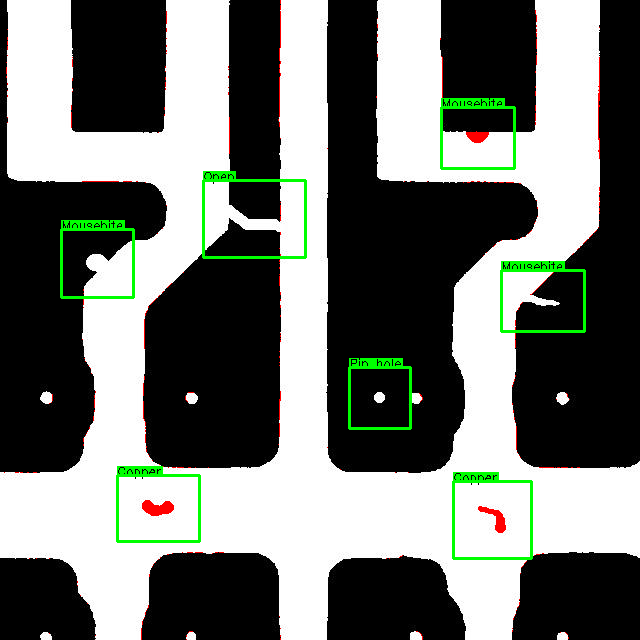

In [ ]:
import torch
from google.colab.patches import cv2_imshow
model = Net()
model.load_state_dict(torch.load("/content/drive/MyDrive/final_year_project/eff-b4-ns/resnet152-0.9722222222222222.pth"))
model.eval()
output = model_inference(model,"/content/DeepPCB/PCBData/group92000/92000/92000115_temp.jpg","/content/DeepPCB/PCBData/group92000/92000/92000115_test.jpg",test_aug)
cv2_imshow(output)